# COVID-ASKME: smart FAQ information retrieval

O objetivo deste projeto passa por tentar ajudar as pessoas a encontrar informação sobre o vírus **COVID-19**. A ideia é recomendar um conjunto de perguntas/respostas que mais se assemelham à pergunta feita pelo utilizador. Isto poderá ajudar o utilizador a usufruir de um conjunto de informação mais direcionada à sua procura.  

Para tal, foram extraídas um conjunto de FAQs de diferentes entidades (**DGS**, **SNS24** , **ESTAMOS ON** e **Seg-social**) de forma a criar um repositório com esta informação. Uma vez que as diferentes FAQs geralmente estão organizadas por categorias com alguma granularidade (ex: Educação, perguntas básicas sobre a covid-19, saúde, grupos de risco, etc..), decidimos criar categorias mais generalistas representadas na figura em baixo. 

Com estas categorias definidas, o primeiro passo da pipeline passa por prever a categoria da pergunta do utilizador. De seguida, com base na categoria prevista será recomendado um conjunto de perguntas que mais se assemelham com a pergunta feita pelo utilizador. As previsões e recomendações serão geradas através de modelos de machine learning.

Sendo este projeto apenas uma prova de conceito são necessárias melhorias na metodologia, bem como a inclusão de mais dados para que as recomendações sejam mais eficientes. Desta forma, este notebook poderá ser uma baseline para quem tiver interesse em fazer análise e processamento de texto (NLP) dentro deste contexto.   





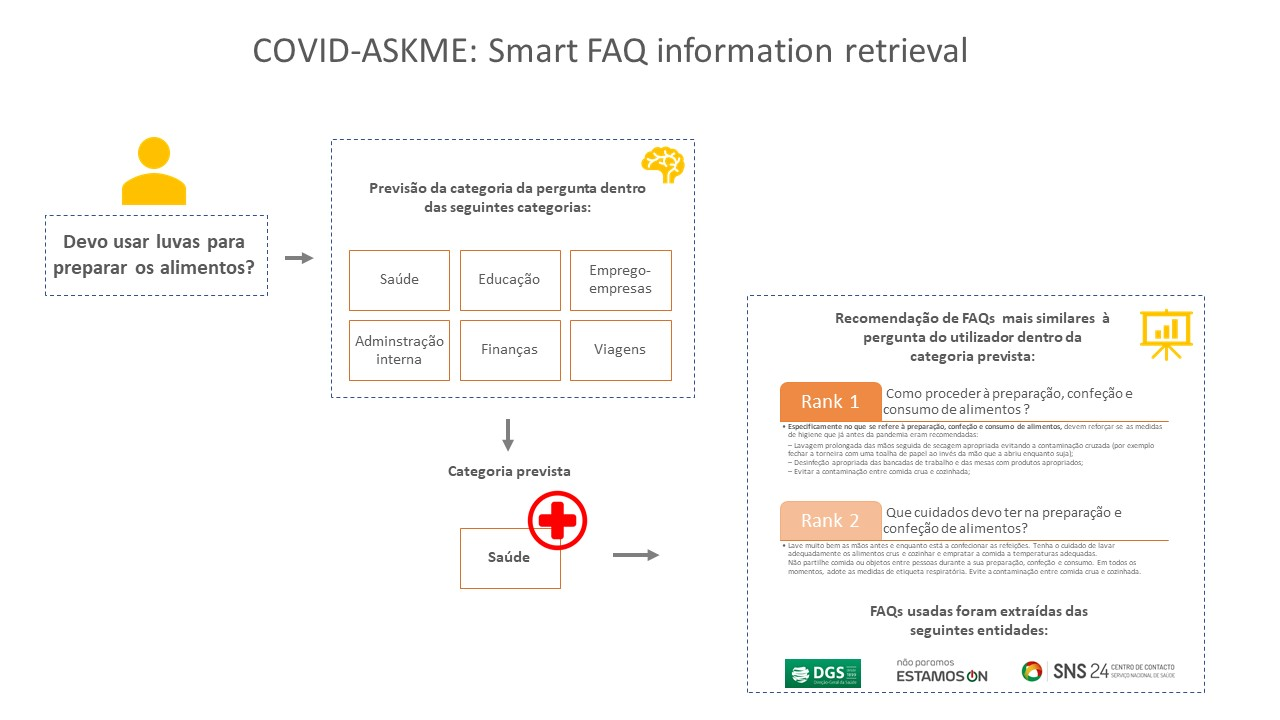

In [1]:
from IPython.display import Image
Image(filename = 'images/application.jpg', width=1000, height=1000)

# Índice

1. [Importação dos dados e packages](#1.-Importação-dos-dados-e-packages)
2. [Pré-processamento dos dados](#2.-Pré-processamento-dos-dados)
3. [Análise exploratória dos dados (EDA)](#3.-Análise-exploratória-dos-dados-(EDA))
4. [Desevolvimento modelo de previsão da categoria](#4.-Desevolvimento-modelo-de-previsão-da-categoria)
5. [Desevolvimento modelo de recomendação de FAQ's](#5.-Desevolvimento-modelo-de-recomendação-de-FAQ's)
6. [Aplicação end-to-end](#6.-Aplicação-end-to-end)
7. [Conclusões](#7.-Conclusões)
8. [Referências](#8-Referências)


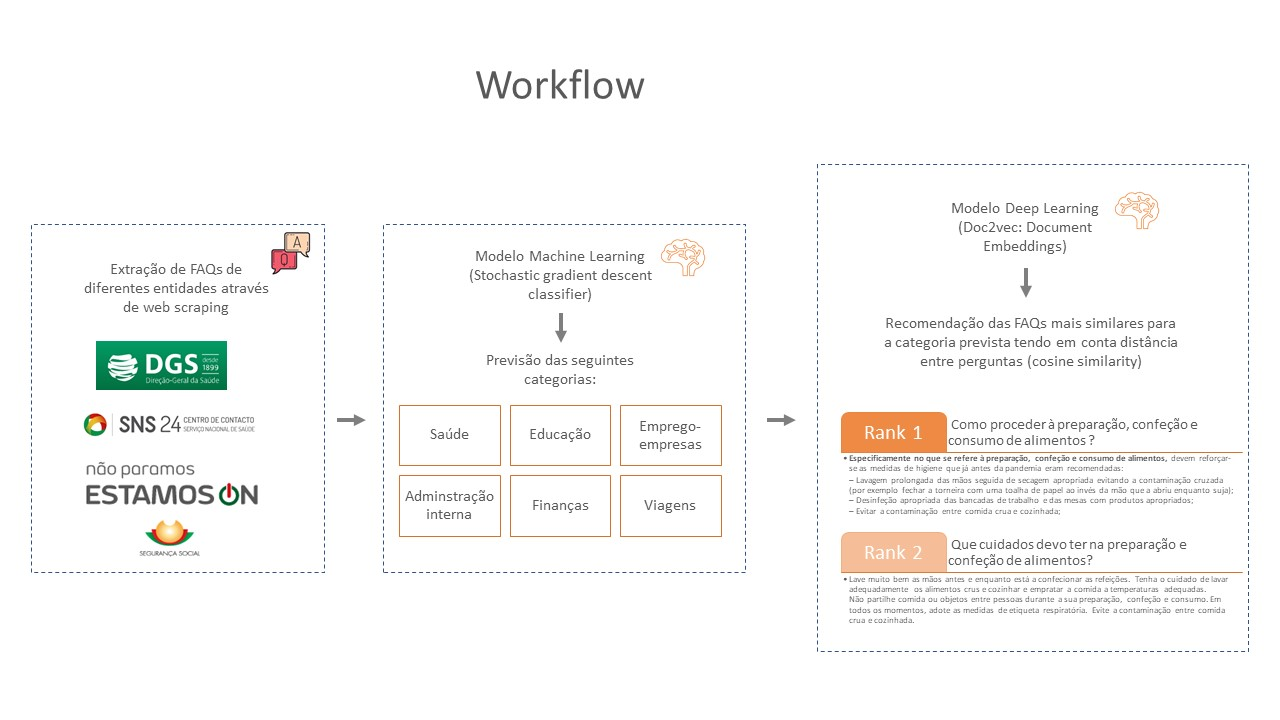

In [2]:
Image(filename = 'images/workflow.jpg', width=1000, height=1000)

## 1. Importação dos dados e packages

In [3]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import unidecode
import re
import collections
import scipy 

# Sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models
from gensim import similarities

import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [4]:
# Functions

def load_stop_words(file):
    stop_words = open(file, 'r')
    stop_words = stop_words.readlines()
    stop_words = [word.replace('\n','') for word in stop_words]
    return stop_words


def remove_stopwords_tokenize(texts=None, deacc=True, stop_words=None):
    if deacc:
        tokens = simple_preprocess(str(texts), deacc)
        # remove accents from stopwords
        stop_words = [unidecode.unidecode(word) for word in stop_words]
        tokens = [word for word in tokens if word not in stop_words]
        return tokens
    else:
        tokens = simple_preprocess(str(texts), deacc)
        tokens = [word for word in tokens if word not in stop_words]
        return tokens

    
# takes into account category
def prepare_corpus_category(docs=None, stop_words=None, rm_stopwords=True, deacc=True, labels=True):
        for i, line in enumerate(docs):
            # deacc with stop_words
            if deacc:
                tokens = gensim.utils.simple_preprocess(line[0], deacc)
                if rm_stopwords:
                    # remove accents from stopwords 
                    stop_words = [unidecode.unidecode(word) for word in stop_words]
                    tokens = [token for token in tokens if token not in stop_words]
            # without deacc          
            else:
                tokens = gensim.utils.simple_preprocess(line[0], deacc)
            
             # with stopwords without deacc 
            if rm_stopwords and not deacc:
                tokens = [token for token in tokens if token not in stop_words]
            if labels: 
                # line[1] corresponds to the tag label
                yield gensim.models.doc2vec.TaggedDocument(tokens, [line[1]])
            else:
                yield tokens 

                
def remap_categories(data):
    
    if data in  ['perguntas básicas sobre a covid-19','transmissão da doença','gravidez','o tabaco e a covid-19',
                'medidas de prevenção','transmissão da doença','tratamento e vacina',
                'grupos de risco','isolamento','estigma']:
        return 'saude'
    elif data in ['trabalhador em isolamento', 'trabalhador doente', 'assistência a filho ou a neto', 'trabalhadores independentes', 
                  'trabalhador em isolamento com teletrabalho','entidades empregadoras']:
        return 'emprego-empresas'
    else:
        return data

    
def clean_data(data=None, stop_words=None, rm_stopwords=True, deacc=True):
    for doc in data:
        if deacc:
                tokens = gensim.utils.simple_preprocess(doc, deacc)
                if rm_stopwords:
                    # remove accents
                    stop_words = [unidecode.unidecode(word) for word in stop_words]
                    tokens = [word for word in tokens if word not in stop_words]
        else:
            tokens = gensim.utils.simple_preprocess(doc, deacc)
        
        yield ' '.join(tokens)



def prepare_corpus_similarity(docs=None, stop_words=None, rm_stopwords=True, deacc=True, labels=True):
        for i, line in enumerate(docs):
            # deacc with stop_words
            if deacc:
                tokens = gensim.utils.simple_preprocess(line[0], deacc)
                if rm_stopwords:
                    # remove accents from stopwords 
                    stop_words = [unidecode.unidecode(word) for word in stop_words]
                    tokens = [word for word in tokens if word not in stop_words]
            # without deacc        
            else:
                tokens = gensim.utils.simple_preprocess(line[0], deacc)
            
            # with stopwords without deacc 
            if rm_stopwords and not deacc:
                tokens = [token for token in tokens if token not in stop_words]
            
            if labels: 
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            else:
                yield tokens        

                
def prepare_query(sentence=None, stop_words=None, rm_stopwords=True, deacc=True):
        if deacc:
                tokens = gensim.utils.simple_preprocess(sentence, deacc)
                if rm_stopwords:
                    # remove accents
                    stop_words = [unidecode.unidecode(word) for word in stop_words]
                    tokens = [word for word in tokens if word not in stop_words]
        else:
                tokens = gensim.utils.simple_preprocess(sentence, deacc)
            
        if rm_stopwords:
            tokens = [token for token in tokens if token not in stop_words]
            return tokens
        else:       
            return tokens
 

def get_embeddings(data, model):
    sentence_vectors = []
    model.random.seed(0)
    for index in range(data.shape[0]):
       
        sentence_vectors.append(model.infer_vector(data.corpus.iloc[index].words))
        
    return sentence_vectors


def recommend_faq(input_sentence, clf, model, stop_words, n_records, 
                 train_doc2_vec_corpus, X_train, y_train, dataset, 
                 evaluate, plot_answers):

    input_cleaned = list(clean_data(input_sentence, stop_words))
    test_idf = vectorizer.transform(input_cleaned)
    predicted_category = clf.predict(test_idf)[0]
    
    sentence_corpus = prepare_query(sentence=input_sentence[0], stop_words=stop_words, rm_stopwords=True, deacc=True)
    model.random.seed(0)
    inferred_vector = model.infer_vector(sentence_corpus)

    subset = pd.DataFrame(list(zip(train_doc2_vec_corpus, X_train, y_train)), columns = ['corpus','sentence','category'])
    subset_by_category = subset[subset.category == predicted_category]

    train_vectors_by_category = get_embeddings(subset_by_category, model)
    similarity_scores = [cosine_similarity([inferred_vector], [vector])[0][0] for vector in train_vectors_by_category]

    results = pd.DataFrame(list(zip(similarity_scores, subset_by_category.sentence)), columns = ['score','sentence'])
    results.sort_values(by=['score'],inplace=True, ascending = False)

    print('Sentence: {} \n'.format(input_sentence[0]))
    print('Predicted category: {}'.format(predicted_category))
    if evaluate:
         print('Real category: {}'.format(evaluate))
    print('Recomendations: \n')
    if plot_answers:
        for i, val in enumerate(list(results.score[0:n_records])):
            print(val, results.sentence.iloc[i])
            print('Response: {}'.format(dataset[dataset.Pergunta == results.sentence.iloc[i]].Resposta.iloc[0]))
            print('Source: {}\n'.format(dataset[dataset.Pergunta == results.sentence.iloc[i]].Source.iloc[0]))
    else:
        for i, val in enumerate(list(results.score[0:n_records])):
            print(val, results.sentence.iloc[i])

In [5]:
# load FAQ data from DGS
with open('data/FAQ_DGS.json') as json_file:
     faq_dgs = json.load(json_file)   
        
# load FAQ data from ESTAMOS_ON
with open('data/FAQ_ESTAMOS_ON.json') as json_file:
     faq_eston = json.load(json_file)              

# Load manual extraction from SNS24-Viagens and Segurança Social         
manual_extraction = pd.read_excel('data/Manual_extraction.xlsx')        

In [6]:
faq_dgs[0:2]

[{'question': 'O que são os Coronavírus?',
  'answer': 'Os coronavírus pertencem à família Coronaviridae que integra vírus que podem causar infeção no Homem, noutros mamíferos (por exemplo nos morcegos, camelos, civetas) e nas aves. Até à data, conhecemos oito coronavírus que infetam e podem causar doença no Homem. Normalmente, estas infeções afetam o sistema respiratório, podendo ser semelhantes às constipações comuns ou evoluir para uma doença mais grave, como a pneumonia. Dos coronavírus que infetam o Homem o SARS-CoV, o MERS-CoV e o SARS-CoV-2 saltaram a barreira das espécies, ou seja, estes vírus foram transmitidos ao Homem a partir de um animal reservatório ou hospedeiro desses vírus. O SARS-CoV originou uma epidemia em 2002-2003 e o MERS-CoV emergiu em 2012 e foi causando casos esporádicos de infeção humana ou pequenos clusters de casos de doença respiratória. O novo coronavírus, o SARS-CoV-2, que origina a doença designada COVID-19, foi identificado pela primeira vez em dezembr

In [7]:
faq_eston[0:2]

[{'question': '\nAs rendas que deixar de pagar durante o Estado de Emergência têm de ser pagas depois?\n',
  'category': 'emprego-empresas',
  'answer': '\nTêm. Não se trata de uma suspensão/isenção, mas sim de um diferimento. As rendas não pagas nesse período terão de ser pagas nos 12 meses posteriores ao término desse período, em prestações mensais não inferiores a um duodécimo do montante total, pagas juntamente com a renda do mês em causa. \n'},
 {'question': '\nComo se está a preparar o IAPMEI? \n',
  'category': 'emprego-empresas',
  'answer': '\n\nReafectação de tarefas de colaboradores para reforço da capacidade de resposta ao nível dos sistemas de incentivos\nDisponibilização no sítio de Internet de uma área especifica para prestar informações sobre o pacote de medidas direcionadas para as empresas neste âmbito.\nFoi reforçado o atendimento online e telefónico, tendo sido ativada a rede descentralizada de apoio:\n\n\n\n\nAveiro\n(+351) 234 302 450\n\n\nBraga\n(+351) 253 206 60

## 2. Pré-processamento dos dados

Após extracção dos dados das diferentes entidades, é necessario fazer um primeiro processamento antes de avançar com uma análise exploratória. 

### 2.1 Dados ESTAMOS ON

In [8]:
# convert to dataframe
data_eston = pd.DataFrame.from_dict(faq_eston, orient='columns')
data_eston = data_eston[['question','answer', 'category']]
data_eston.columns = ['Pergunta','Resposta','Categoria']

In [9]:
# Remove \n and lower case
data_eston['Pergunta'] = data_eston.Pergunta.apply(lambda sentence: sentence.replace('\n','').lower())
data_eston['Resposta'] = data_eston.Resposta.apply(lambda answer: answer.replace('\n','').lower())
# Add source column
data_eston['Source'] = 'Estamos On'.lower()

In [10]:
data_eston.head()

,Pergunta,Resposta,Categoria,Source
0,as rendas que deixar de pagar durante o estado...,"têm. não se trata de uma suspensão/isenção, ma...",emprego-empresas,estamos on
1,como se está a preparar o iapmei?,reafectação de tarefas de colaboradores para r...,emprego-empresas,estamos on
2,"e se eu, inquilino, decidir denunciar o contra...",a cessação do contrato por iniciativa do arren...,emprego-empresas,estamos on
3,o que é a linha de crédito para agências de vi...,quais os principais destinatários?empresas (de...,emprego-empresas,estamos on
4,o que é a linha de crédito para indústria - tê...,quais os principais destinatários?empresas (de...,emprego-empresas,estamos on


### 2.2 Dados DGS

In [11]:
# convert to dataframe
data_dgs = pd.DataFrame.from_dict(faq_dgs, orient='columns')
data_dgs = data_dgs[['question','answer', 'category']]
data_dgs.columns = ['Pergunta','Resposta','Categoria']

In [12]:
# add source column
data_dgs['Source'] = 'dgs'
# lower case data
data_dgs['Pergunta'] = data_dgs.Pergunta.apply(lambda x: x.lower())
data_dgs['Resposta'] = data_dgs.Resposta.apply(lambda x: x.lower())
data_dgs['Categoria'] = data_dgs.Categoria.apply(lambda x: x.lower())

In [13]:
data_dgs.head()

,Pergunta,Resposta,Categoria,Source
0,o que são os coronavírus?,os coronavírus pertencem à família coronavirid...,perguntas básicas sobre a covid-19,dgs
1,o que é o novo coronavírus?,"o novo coronavírus, designado sars-cov-2, foi ...",perguntas básicas sobre a covid-19,dgs
2,o que é a covid-19?,covid-19 é a designação dada pela organização ...,perguntas básicas sobre a covid-19,dgs
3,sars-cov-2 é o mesmo que covid-19?,sars-cov-2 é o nome do novo vírus e significa ...,perguntas básicas sobre a covid-19,dgs
4,qual é a origem do novo coronavírus?,supõe-se que o sars-cov-2 tenha sido introduzi...,perguntas básicas sobre a covid-19,dgs


### 2.3 Dados extracidos de forma manual (SNS 24 Perguntas viajante, FAQ segurança social)

Na extração destes dados não foi usado um método automático como os métodos de scraping usados nas restantes FAQs. Uma vez que eram poucos casos foi mais rápido fazer a extração de forma manual.

In [14]:
# lower case data
manual_extraction['Source'] = manual_extraction.Source.apply(lambda x: x.lower())
manual_extraction['Pergunta'] = manual_extraction.Pergunta.apply(lambda x: x.lower())
manual_extraction['Resposta'] = manual_extraction.Resposta.apply(lambda x: x.lower())
manual_extraction['Categoria'] = manual_extraction.Categoria.apply(lambda x: x.lower())

In [15]:
manual_extraction.head()

,Pergunta,Resposta,Categoria,Source,Link
0,se um trabalhador se encontrar impedido tempor...,sim. se tiver uma declaração de isolamen...,trabalhador em isolamento,segurança social,http://www.seg-social.pt/covid-19-perguntas-e-...
1,como é emitida a declaração da situação de iso...,a declaração é emitida pela autoridade de saúd...,trabalhador em isolamento,segurança social,http://www.seg-social.pt/covid-19-perguntas-e-...
2,quem é a autoridade de saúde competente?,a autoridade de saúde (também conhecido como d...,trabalhador em isolamento,segurança social,http://www.seg-social.pt/covid-19-perguntas-e-...
3,como se desencadeia o processo para que uma pe...,o processo tem sempre de ser desencadeado pela...,trabalhador em isolamento,segurança social,http://www.seg-social.pt/covid-19-perguntas-e-...
4,quem envia a declaração? e para onde?,o trabalhador deve enviar a sua declaração de ...,trabalhador em isolamento,segurança social,http://www.seg-social.pt/covid-19-perguntas-e-...


In [16]:
# filter just the columns that we need
data_others = manual_extraction[['Pergunta','Resposta','Categoria','Source']]

In [17]:
data_others.head(5)

,Pergunta,Resposta,Categoria,Source
0,se um trabalhador se encontrar impedido tempor...,sim. se tiver uma declaração de isolamen...,trabalhador em isolamento,segurança social
1,como é emitida a declaração da situação de iso...,a declaração é emitida pela autoridade de saúd...,trabalhador em isolamento,segurança social
2,quem é a autoridade de saúde competente?,a autoridade de saúde (também conhecido como d...,trabalhador em isolamento,segurança social
3,como se desencadeia o processo para que uma pe...,o processo tem sempre de ser desencadeado pela...,trabalhador em isolamento,segurança social
4,quem envia a declaração? e para onde?,o trabalhador deve enviar a sua declaração de ...,trabalhador em isolamento,segurança social


### 2.4 Compilação das diferentes fontes

In [18]:
# merge all data sources
dataset = pd.concat([data_dgs, data_eston, data_others], axis =0)
# re-order dataset columns
dataset = dataset[['Pergunta','Resposta','Categoria','Source']]

Este é o dataset compilado das diferentes entidades. Para cada entidade temos a pergunta/resposta e respectivas categorias definidas pelas entidades.

In [19]:
dataset.sample(frac=1).head(10) 

,Pergunta,Resposta,Categoria,Source
5,já houve algum surto com coronavírus em anos a...,sim. em anos anteriores foram identificados al...,perguntas básicas sobre a covid-19,dgs
52,quem audita os resultados dos testes laborator...,os testes laboratoriais de diagnóstico deste v...,saude,estamos on
47,quantos dias antes dos primeiros sintomas é qu...,estima-se que o período de incubação da doença...,saude,estamos on
56,as mulheres grávidas são mais suscetíveis à in...,"nos trabalhos científicos publicados, não exis...",gravidez,dgs
24,como utilizar máscaras?,"a direção-geral da saúde não recomenda, até ao...",saude,estamos on
6,qual a situação atual e o risco em portugal da...,"face a esta ameaça de saúde pública, foram def...",perguntas básicas sobre a covid-19,dgs
0,o que são os coronavírus?,os coronavírus pertencem à família coronavirid...,perguntas básicas sobre a covid-19,dgs
23,regressei de um país que tinha casos confirmad...,a direção-geral da saúde recomenda que:\n\nvig...,viagens,sns24-viagens
90,a inspeção física e a amostragem sistemática p...,"não. a fim de evitar interrupções no comércio,...",agricultura,estamos on
95,posso aplicar as medidas de exceção determinad...,não. as medidas excecionais determinadas só se...,agricultura,estamos on


### 2.5 Extracção de tokens e stop words

In [20]:
# load Portuguese stopwords
stop_words = load_stop_words('data/stop_words.txt')

In [21]:
# just a sample
stop_words[0:10]

['a',
 'acerca',
 'adeus',
 'agora',
 'ainda',
 'alem',
 'algmas',
 'algo',
 'algumas',
 'alguns']

In [22]:
dataset['Pergunta_clean_tokens'] = dataset.Pergunta.apply(lambda pergunta: remove_stopwords_tokenize(texts=pergunta, 
                                                                                                     deacc=False, 
                                                                                                     stop_words=stop_words))

In [23]:
dataset.head()

,Pergunta,Resposta,Categoria,Source,Pergunta_clean_tokens
0,o que são os coronavírus?,os coronavírus pertencem à família coronavirid...,perguntas básicas sobre a covid-19,dgs,[coronavírus]
1,o que é o novo coronavírus?,"o novo coronavírus, designado sars-cov-2, foi ...",perguntas básicas sobre a covid-19,dgs,[coronavírus]
2,o que é a covid-19?,covid-19 é a designação dada pela organização ...,perguntas básicas sobre a covid-19,dgs,[covid]
3,sars-cov-2 é o mesmo que covid-19?,sars-cov-2 é o nome do novo vírus e significa ...,perguntas básicas sobre a covid-19,dgs,"[sars, cov, covid]"
4,qual é a origem do novo coronavírus?,supõe-se que o sars-cov-2 tenha sido introduzi...,perguntas básicas sobre a covid-19,dgs,"[origem, coronavírus]"


In [24]:
print('Number of samples: {}'.format(dataset.shape))

Number of samples: (236, 5)


In [25]:
dataset.isna().any()

Pergunta                 False
Resposta                 False
Categoria                False
Source                   False
Pergunta_clean_tokens    False
dtype: bool

In [26]:
dataset.isnull().any()

Pergunta                 False
Resposta                 False
Categoria                False
Source                   False
Pergunta_clean_tokens    False
dtype: bool

## 3. Análise exploratória dos dados (EDA)

### 3.1 Categorias

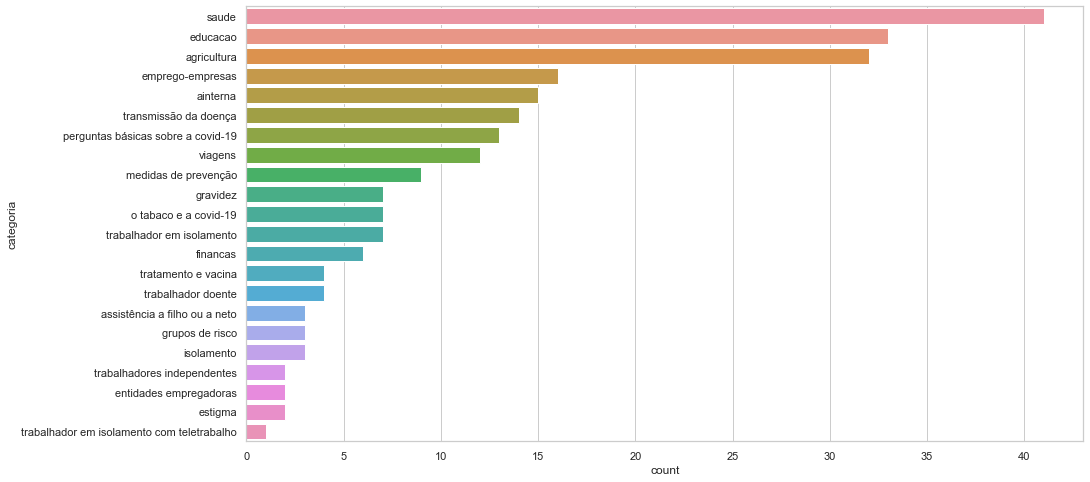

In [27]:
df = pd.DataFrame(dataset.Categoria.value_counts().reset_index())
df.columns = ['categoria','count']
plt.figure(figsize=(15,8))
sns.barplot(x="count", y="categoria", data=df)

### 3.2 Source (Entidades)

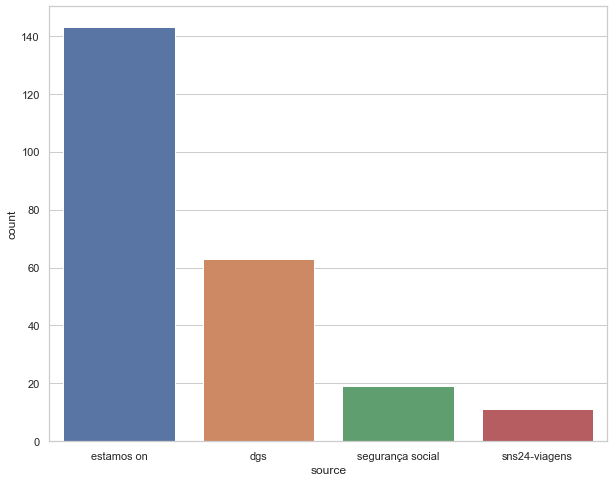

In [28]:
df = pd.DataFrame(dataset.Source.value_counts().reset_index())
df.columns = ['source','count']
plt.figure(figsize=(10,8))
sns.barplot(x="source", y="count", data=df)

### 3.3 Palavras/Frequência

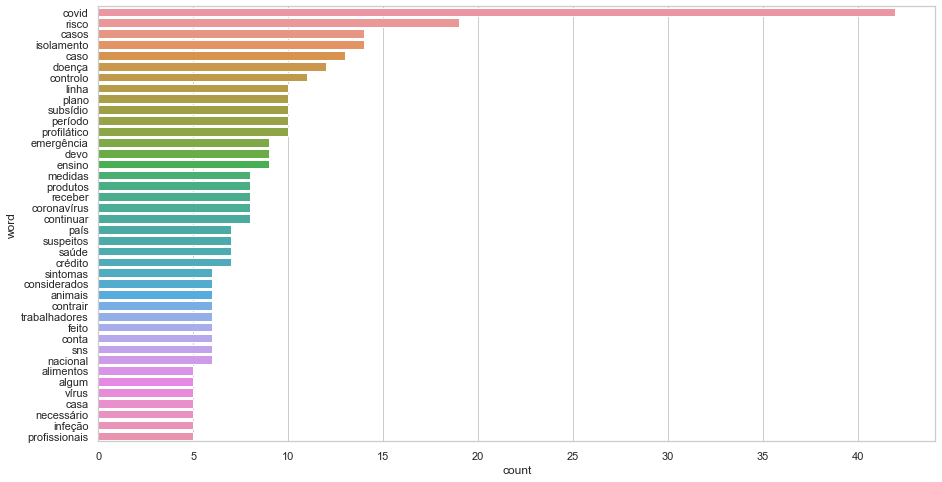

In [29]:
frequency_clean = defaultdict(int)
for words in dataset.Pergunta_clean_tokens:
    for word in words:
        frequency_clean[word] += 1
        
word_count = pd.DataFrame.from_dict(frequency_clean, orient='index').reset_index()
word_count.columns = ['word', 'count'] 
word_count.sort_values(by='count', ascending=False, inplace=True)

plt.figure(figsize=(15,8))
sns.barplot(x="count", y="word", data=word_count.iloc[0:40])

## 4. Desevolvimento modelo de previsão da categoria

Como podemos ver na secção [3.1](#3.1-Categorias) temos bastantes categorias. A ideia é estabelecer categorias mais abrangentes para facilitar a agregação das perguntas pelos tópicos a que se referem. Dessa forma, é necessário re-mapear algumas categorias para categorias mais abrangentes estabelecidas da seguinte forma:  

    - Saúde (transmissão da doença, perguntas básicas sobre a covid-19, o tabaco e a covid-19 , medidas de prevenção, gravidez, isolamento, grupos de risco, tratamento e vacina e estigma)
    - Educação
    - Emprego-Empresas (trabalhador em isolamento, trabalhador doente, assistência a filho ou a neto, trabalhadores independentes, trabalhador em isolamento com teletrabalho)
    - Administração Interna
    - Finanças
    - Viagens

Nesta secção vamos testar dois modelos diferentes ambos relativos a aprendizagem supervisionada, de forma a perceber qual deles terá melhor performance na previsão das categorias das perguntas.

O primeiro modelo (**Doc2vec**) consiste numa rede neural que extrai a semântica do texto de forma a captar o contexto das palavras em cada frase. Este modelo cria vetores (embeddings) com uma determinada dimensão que traduzem a representação desta frases num determinado espaço. Isto faz com que seja possível agregar as frases que têm um contexto semelhante mais próximas umas das outras.

No segundo modelo vamos extrair features do texto usando o método de **TF-IDF**. Este método em relação aos embeddings não capta a relação/semântica entre as palavras. Apenas analisa a frequência das palavras nos vários documentos do corpus que foi usado no treino do modelo. De seguida, usando o algoritmo **stochastic gradient descent (sgd)** vamos avaliar a performance na previsão da categoria.

Isto é uma explicação mais genérica da metodologia. Nas referências podem consultar informação mais detalhada sobre ambos os modelos e técnicas usadas.



### 4.1 Re-mapeamento de categorias

In [30]:
dataset['Categoria'] = dataset.Categoria.apply(lambda x: remap_categories(x))

In [31]:
dataset.Categoria.value_counts()

saude               103
emprego-empresas     35
educacao             33
agricultura          32
ainterna             15
viagens              12
financas              6
Name: Categoria, dtype: int64

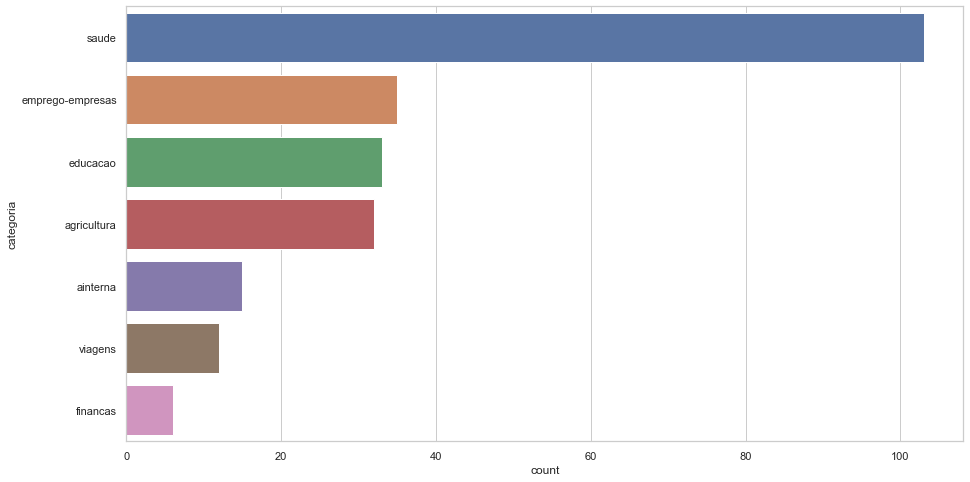

In [32]:
df = pd.DataFrame(dataset.Categoria.value_counts().reset_index())
df.columns = ['categoria','count']
plt.figure(figsize=(15,8))
sns.barplot(x="count", y="categoria", data=df)

### 4.2 Criação de partições (treino e teste)

O dataset vai ser dividido em treino (80%) e teste (20%)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dataset['Pergunta'], dataset['Categoria'], test_size=0.2, random_state=0)

#### 4.2.1 Análise distribuição das categorias 

In [34]:
y_train.value_counts()

saude               82
emprego-empresas    27
educacao            26
agricultura         25
ainterna            12
viagens             11
financas             5
Name: Categoria, dtype: int64

In [35]:
y_test.value_counts()

saude               21
emprego-empresas     8
agricultura          7
educacao             7
ainterna             3
financas             1
viagens              1
Name: Categoria, dtype: int64

### 4.3 Modelo 1: Doc2vec model (Semantic similarity)

#### 4.3.1 Preparação do corpus

A preparação do corpus consiste em criar tokens das respectivas pergutas, remover a acentuação e stop words. Desta forma, o texto ficará mais limpo para a fase de modelação.

In [36]:
# prepare corpus to doc2vec model
train_doc2_vec_corpus = list(prepare_corpus_category(docs = list(zip(X_train, y_train)),
                                           stop_words=stop_words,
                                           rm_stopwords=True,
                                           deacc=True,
                                           labels=True))

In [37]:
# prepare corpus to doc2vec model
test_doc2_vec_corpus = list(prepare_corpus_category(docs = list(zip(X_test, y_test)),                
                                           stop_words=stop_words,
                                           rm_stopwords=True,
                                           deacc=True,
                                           labels=False
                                          ))

In [38]:
train_doc2_vec_corpus[0:2]

[TaggedDocument(words=['precisar', 'servico', 'at'], tags=['financas']),
 TaggedDocument(words=['apurada', 'classificacao'], tags=['educacao'])]

#### 4.3.2 Treino modelo

O modelo foi treinado com os seguintes parâmetros. Foram testadas diferentes configurações na dimensão dos embeddings (50,100 e 300). Uma dimensão de 300 foi a que obteve melhores resultados. No entanto, a avaliação deste parâmetro directamente na partição de teste não é a melhor prática pois podemos estar a fazer overfitting dos parâmetros à partição de teste e os resultados não generalizarem da melhor forma.

O parâmetro **min_count** (ignora todas as palavras que tenham um frequência inferior a esta) foi definido como **1**, uma vez que valores superiores penalizava bastante os resultados. Os restantes parâmetros são default do modelo.

In [39]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=1, epochs=100, dm=1, alpha = 0.25) 
model.random.seed(0)
model.build_vocab(train_doc2_vec_corpus)
# train model
model.train(train_doc2_vec_corpus, total_examples=model.corpus_count, epochs=model.epochs)

#### 4.3.3 Avaliação modelo: partição de treino

A avaliação do modelo foi feita através da análise das previsões geradas na partição de treino. Basicamente, estamos a fazer "overfitting" ao modelo de forma a perceber se este consegue gerar as mesmas previsões sobre as quais foi treinado. 
98% dos casos o modelo consegue prever corretamente. Foi usada uma seed neste código, uma vez que o modelo **Doc2vec** é baseado em processos não deterministicos. Desta forma, aseguramos que sempre que executamos este bloco os vetores e resultados são sempre iguais.

In [40]:
# Assesing model
results = []
second_ranks = []
model.random.seed(0)
for doc_id in range(len(train_doc2_vec_corpus)):
    inferred_vector = model.infer_vector(train_doc2_vec_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    if sims[0][0] == train_doc2_vec_corpus[doc_id].tags[0]:
        results.append('Match')
    else:
        results.append('Mismatch')

counter = collections.Counter(results)
print(counter)
print('Accuracy: {}'.format(counter['Match'] / len(results) *100))        

Counter({'Match': 184, 'Mismatch': 4})
Accuracy: 97.87234042553192


Aqui podemos ver alguns dos exemplos em que o modelo foi treinado e as previsões geradas:

In [41]:
doc_id = 5
print('Document ({}): {}\n'.format(doc_id, X_train.iloc[doc_id]))
print('Real category: {}'.format(train_doc2_vec_corpus[doc_id].tags[0]))
inferred_vector = model.infer_vector(train_doc2_vec_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
sims


Document (5): quais são os grupos considerados de risco para o covid-19?

Real category: saude


[('saude', 0.783276379108429),
 ('ainterna', 0.5782601833343506),
 ('educacao', 0.5663711428642273),
 ('viagens', 0.49297523498535156),
 ('financas', 0.4802628755569458),
 ('emprego-empresas', 0.3473697006702423),
 ('agricultura', 0.3260231018066406)]

#### 4.3.4 Avaliação modelo: partição de teste

Relativamente à partição de teste o modelo consegue prever **79%** das categorias correctamente. Isto pode ser justificado pelo facto de termos um dataset com poucas amostras e pouco balanceado o que faz com que o modelo não generalize da melhor forma nestes casos.

In [42]:
# Assesing model
results = []
second_ranks = []
model.random.seed(0)

for doc_id in range(len(test_doc2_vec_corpus)):
    inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    if sims[0][0] == y_test.iloc[doc_id]:
        results.append('Match')
    else:
        results.append('Mismatch')

counter = collections.Counter(results)
print(counter)
print('Accuracy: {}'.format(counter['Match'] / len(results) *100))        

Counter({'Match': 38, 'Mismatch': 10})
Accuracy: 79.16666666666666


Aqui vemos algumas das previsões geradas. 

In [43]:
doc_id = 8
print('Document ({}): {}\n'.format(doc_id, X_test.iloc[doc_id]))
print('Real category: {}'.format(y_test.iloc[doc_id]))
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
sims

Document (8): o que devem ter em conta os outros membros da casa?

Real category: saude


[('educacao', 0.5022031664848328),
 ('saude', 0.4623265862464905),
 ('ainterna', 0.36092305183410645),
 ('viagens', 0.34820079803466797),
 ('agricultura', 0.27298566699028015),
 ('financas', 0.18712973594665527),
 ('emprego-empresas', 0.1304609179496765)]

Neste exemplo vemos um dos casos em que a categoria é incorretamente prevista. 

In [44]:
doc_id = 13
print('Document ({}): {}\n'.format(doc_id, X_test.iloc[doc_id]))
print('Real category: {}'.format(y_test.iloc[doc_id]))
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
sims

Document (13): o serviço de receitas de medicamentos por telemóvel alterou sendo agora necessária a chave móvel digital. quem não tem, como pode levantar os medicamentos?

Real category: saude


[('financas', 0.7836951613426208),
 ('emprego-empresas', 0.34529319405555725),
 ('agricultura', 0.34526708722114563),
 ('ainterna', 0.2415897697210312),
 ('saude', 0.23600992560386658),
 ('viagens', 0.2266211211681366),
 ('educacao', 0.13326293230056763)]

Testamos várias configurações no treino do modelo de forma a perceber se a remoção das stop words e da acentuação penalizava o modelo de alguma forma. O que podemos ver foi que usando estes métodos de processamento obtemos melhores resultados.  

### 4.4 Modelo 2: Stochastic gradient descent model with TF-IDF  

#### 4.4.1 Processamento dos dados

Nesta primeira fase vamos processar os dados, removendo algumas stop words e retirar a acentuação.

In [45]:
# apply data cleaning before create TF-IDF 
df_train = list(clean_data(data=X_train, stop_words=stop_words, rm_stopwords=True, deacc=True))
df_test = list(clean_data(data=X_test, stop_words=stop_words, rm_stopwords=True, deacc=True))

In [46]:
df_train[0:5]

['precisar servico at',
 'apurada classificacao',
 'lecionadas materias existe consolidacao conhecimentos',
 'tempos distanciamento social funciona processo sangue existe linha linhas agendamento',
 'feito report dados positivos confirmados casos analiados dgs']

#### 4.4.2 Extracção de features do texto através do método TF-IDF

In [47]:
# apply TF-IDF
vectorizer = TfidfVectorizer()
train = vectorizer.fit_transform(df_train)
test = vectorizer.transform(df_test)

#### 4.4.3 Treino modelo

Vamos usar diferentes configurações na loss function do modelo, de forma a avaliar qual delas se ajusta melhor aos nossos dados. Para decidir qual a melhor configuração, será usada a métrica de cross validation usando a média da accuracy nas 5 folds. 

In [48]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
clf_1 = linear_model.SGDClassifier(max_iter=1000, loss = 'hinge', random_state=42)
clf_2 = linear_model.SGDClassifier(max_iter=1000, loss = 'log', random_state=42)
clf_3 = linear_model.SGDClassifier(max_iter=1000, loss = 'perceptron', random_state=42)
clf_4 = linear_model.SGDClassifier(max_iter=1000, loss = 'squared_hinge', random_state=42)


#### 4.4.3.1 Avaliação modelo: Treino

In [49]:
print('Cross-validation scores with 5 folds:')
print('model 1: {}'.format(cross_val_score(clf_1, train, y_train, cv=5).mean()))
print('model 2: {}'.format(cross_val_score(clf_2, train, y_train, cv=5).mean()))
print('model 3: {}'.format(cross_val_score(clf_3, train, y_train, cv=5).mean()))
print('model 4: {}'.format(cross_val_score(clf_4, train, y_train, cv=5).mean()))



Cross-validation scores with 5 folds:
model 1: 0.785126120491974
model 2: 0.8180321033979571
model 3: 0.7406816760475297
model 4: 0.6731290389826976


Tendo em conta os resultados a configuração que será usada consiste numa **regressão logística** usando o método de **stochastic gradient descent (sgd)** para otimização da função de custo.  

In [50]:
#Train best configuration
clf = linear_model.SGDClassifier(max_iter=1000, loss = 'log', random_state=42)
clf.fit(train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

#### 4.4.3.1 Avaliação modelo: Teste

Usando este modelo, **83%** dos casos são correctamente previstos. Estes resultados são superiores ao modelo anterior. Desta forma, vamos usar este modelo na previsão da categoria.   

In [51]:
clf.score(test, y_test)

0.8333333333333334

## 5. Desevolvimento modelo de recomendação de FAQ's


A ideia deste modelo é recomendar as perguntas e respectivas respostas que mais se assemelham à pergunta do utilizador.

Vamos usar novamente o modelo **Doc2vec** para extrair os vetores (embeddings) que traduzem o contexto da frase num espaço numérico. A diferença para o modelo anterior é que agora não será usada a "Tag" label usada para prever a categoria.

De seguida, será gerado um rankig das respectivas FAQs usando uma métrica de similaridade entre vetores (cosine similarity). Esta métrica consiste em avaliar o coseno do ângulo entre os vetores, sendo que pode variar entre (-1,1). O valor 1 corresponde a frases mais similares dado que ambos os vetores dos documentos apontam para a mesma direção (angulo 0°). O valor 0 corresponde a ortogonalidade (angulo 90°) traduzindo-se em pouco semelhança. O valor -1 corresponde a ângulos opostos (180°) entre vetores e nenhuma semelhança entre documentos. 


#### 5.1 Preparação do corpus

In [52]:
# prepare corpus to doc2vec model
train_doc2_vec_corpus = list(prepare_corpus_similarity(docs = list(zip(X_train)),
                                           stop_words=stop_words,
                                           rm_stopwords=True,
                                           deacc=True,
                                           labels=True))


# prepare corpus to doc2vec model
test_doc2_vec_corpus = list(prepare_corpus_similarity(docs = list(zip(X_test)),
                                           stop_words=stop_words,
                                           rm_stopwords=True,
                                           deacc=True,
                                           labels=False
                                          ))

In [53]:
train_doc2_vec_corpus[0:5]

[TaggedDocument(words=['precisar', 'servico', 'at'], tags=[0]),
 TaggedDocument(words=['apurada', 'classificacao'], tags=[1]),
 TaggedDocument(words=['lecionadas', 'materias', 'existe', 'consolidacao', 'conhecimentos'], tags=[2]),
 TaggedDocument(words=['tempos', 'distanciamento', 'social', 'funciona', 'processo', 'sangue', 'existe', 'linha', 'linhas', 'agendamento'], tags=[3]),
 TaggedDocument(words=['feito', 'report', 'dados', 'positivos', 'confirmados', 'casos', 'analiados', 'dgs'], tags=[4])]

#### 5.2 Treino modelo

In [54]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=100, dm=1,alpha = 0.25) 
model.random.seed(0)
model.build_vocab(train_doc2_vec_corpus)
# train model
model.train(train_doc2_vec_corpus, total_examples=model.corpus_count, epochs=model.epochs)

#### 5.2.1 Avaliação modelo: partição de treino

Uma forma de avaliar o modelo nesta fase é gerar embeddings para os dados de treino e de seguida analisar se o documento mais próximo no corpus de treino corresponde a ele próprio. Quantos menos registos tivermos dentro do dicionário **counter**, melhor performance o nosso modelo terá.   

In [55]:
# Assesing model 
ranks = []
second_ranks = []
model.random.seed(0)
for doc_id in range(len(train_doc2_vec_corpus)):
    inferred_vector = model.infer_vector(train_doc2_vec_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])
    
counter = collections.Counter(ranks)
print(counter)
print('Accuracy: {}'.format(counter[0] / sum(counter.values()) *100))  

Counter({0: 182, 1: 6})
Accuracy: 96.80851063829788


#### 5.2.2 Avaliação modelo: partição de teste

A avaliação do modelo na partição de teste vai ser feita de forma manual. Basicamente, vamos olhar para algumas amostras e avaliar se as recomendações que são dadas pelo modelo fazem algum sentido. 

In [56]:
doc_id = 5
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): {}\n'.format(doc_id,  X_test.iloc[doc_id]))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: %s\n' % (label, sims[index], X_train.iloc[sims[index][0]]))

Test Document (5): como se processa o envio da/s declaração/ões de isolamento profilático dos trabalhadores para a segurança social?

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,s0.001,t3):

MOST (35, 0.4112434685230255): quem envia a declaração? e para onde?

MEDIAN (177, -0.01994057558476925): os fumadores estão em maior risco de doença grave por covid-19?

LEAST (124, -0.32590311765670776): os testes laboratoriais são inseridos em base de dados para fins de investigação ao novo coronavírus?



Neste exemplo a primeira e a segunda recomendação estão relacionadas com a categoria **administração interna**. No entanto, vemos referências a perguntas sobre **agricultura** na posição 3 o que não faz muito sentido. 

In [57]:
doc_id = 6
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: o plano nacional de emergência tem correspondência com os planos distritais e/ou municipais de emergência?
Real category: ainterna

(51, 0.912956714630127) o que é o plano nacional de emergência? ainterna
(106, 0.9056962132453918) durante quanto tempo o plano nacional de emergência estará ativado? ainterna
(81, 0.7724384069442749) quais são as responsabilidades da autoridade veterinária nacional nesta situação? agricultura
(42, 0.7480165362358093) o que significa a ativação do plano nacional de emergência? ainterna
(182, 0.738857626914978) quais são as novas datas do concurso nacional de acesso? educacao
(100, 0.6876586675643921) qual o âmbito de aplicação do plano? ainterna
(32, 0.6517277359962463) como posso pagar os meus impostos? financas
(139, 0.6375600099563599) devem os organismos de controlo e certificação (oc) suspender igualmente a emissão de documentos para os operadores durante o período de emergência sanitária, nomeadamente os certificados? agricultura
(71, 0.633

Neste exemplo a primeira e a terceira recomendação estão descontextualizadas. No entanto a segunda recomendação já se assemelha um pouco mais com a pergunta.

In [58]:
doc_id = 10
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: todos os hospitais poderão servir como unidades de internamento ou só os considerados unidades de referência?
Real category: saude

(48, 0.4018019735813141) podem continuar a ser realizadas deslocações a apiários por técnicos apícolas?  agricultura
(116, 0.3891189694404602) onde encontrar a lista de hospitais de referência, bem como os laboratórios? saude
(138, 0.38779324293136597) podem continuar a ser realizadas deslocações a unidades de produção primárias por técnicos apícolas?  agricultura
(165, 0.3757340610027313) é necessário o internamento em todos os casos? saude
(64, 0.36955684423446655) o que são considerados contactos próximos do doente no avião? viagens
(63, 0.31928539276123047) podem continuar a ser realizadas deslocações a apiários por apicultores?  agricultura
(115, 0.3162727653980255) todos os laboratórios hospitalares estão ou podem estar preparados para fazer testes laboratoriais, a casos suspeitos? saude
(180, 0.3064362406730652) é necessário o internamento

In [59]:
doc_id = 18
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: se as notas do exame não contam, não haverá inflação de notas?
Real category: educacao

(53, 0.6914442181587219) as notas dos exames nacionais continuam a ser utilizadas como critério para o acesso ao ensino superior? educacao
(97, 0.600771963596344) haverá mais garantias para os créditos que contraí para exportar produtos portugueses para o estrangeiro? agricultura
(149, 0.5604847073554993) haverá mais medidas associadas ao pdr2020? agricultura
(41, 0.5600088834762573) haverá avaliação no terceiro período? educacao
(14, 0.47702595591545105) quando começam as aulas do primeiro ano letivo de 2020/2021 no ensino superior? educacao
(111, 0.4760066270828247) porque se mantêm apenas os exames nacionais no ensino secundário? educacao
(101, 0.4435531795024872) há alterações nos exames nacionais? educacao
(182, 0.44138649106025696) quais são as novas datas do concurso nacional de acesso? educacao
(122, 0.4410913586616516) há alteração nas datas dos exames nacionais? educacao
(157, 0.

In [60]:
doc_id = 21
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: em caso de o sns 24, não atender o que faço?
Real category: saude

(88, 0.6299620270729065) o e-mail atendimento@sns.gov.pt substitui a linha sns24? saude
(137, 0.6211076378822327) quem atende a linha sns 24? onde?  saude
(147, 0.6091985702514648) caso uma feira ou outro evento de promoção de produtos seja cancelado devido à pandemia covid-19, quais as minhas garantias? agricultura
(154, 0.5785423517227173) corro riscos ao viajar no mesmo avião que um caso suspeito? viagens
(102, 0.5564521551132202) o que deve ser feito se validarem um caso suspeito a bordo de um navio? viagens
(25, 0.5150963068008423) há uma temperatura mínima para lavar a roupa quando há um caso confirmado de covid-19 em casa? saude
(12, 0.5113552808761597) no caso dos trabalhadores independentes como serão calculados os rendimentos de referência para efeitos de determinação do montante a receber por isolamento profilático? emprego-empresas
(159, 0.5075364708900452) esta é uma situação dinâmica. caso seja n

In [61]:
doc_id = 30
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: no caso de contrair a doença quem emite o cit?
Real category: emprego-empresas

(174, 0.47689929604530334) se o trabalhador estiver em isolamento profilático, mas contrair doença antes do prazo dos 14 dias passa a receber apenas 55% da remuneração de referência? emprego-empresas
(173, 0.43792688846588135) confirma-se o desaconselhamento da toma de anti-inflamatórios não esteroides e corticóides em caso de infeção respiratória de origem viral? saude
(59, 0.4331592917442322) se for decretado isolamento profilático, mas existirem condições para trabalhar em regime de teletrabalho, ou recorrendo a ações de formação à distância, há direito ao subsídio equivalente ao subsídio de doença? emprego-empresas
(83, 0.43166491389274597) no caso de cura do vírus após primeira infecção, o corpo desenvolve imunidade perante o vírus que o impeça de voltar a revelar-se infectado? saude
(25, 0.43076691031455994) há uma temperatura mínima para lavar a roupa quando há um caso confirmado de covid-1

In [62]:
doc_id = 14
model.random.seed(0)
inferred_vector = model.infer_vector(test_doc2_vec_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Document: {}'.format(X_test.iloc[doc_id]))
print('Real category: {}\n'.format(y_test.iloc[doc_id]))
for i in sims[0:10]:
    print(i, X_train.iloc[i[0]], y_train.iloc[i[0]])

Document: o que são considerados contactos próximos do doente no navio?
Real category: viagens

(102, 0.7507453560829163) o que deve ser feito se validarem um caso suspeito a bordo de um navio? viagens
(11, 0.7147128582000732) existem recomendações específicas para casos suspeitos num avião? viagens
(64, 0.6904605627059937) o que são considerados contactos próximos do doente no avião? viagens
(94, 0.6877102255821228) existem recomendações específicas para casos suspeitos num navio? viagens
(110, 0.649960458278656) o que deve ser feito se validarem um caso suspeito a bordo de um avião? viagens
(78, 0.5377503037452698) quais são as recomendações para os viajantes? viagens
(154, 0.5154311060905457) corro riscos ao viajar no mesmo avião que um caso suspeito? viagens
(107, 0.49941185116767883) como deve ser feito o requerimento para atribuição do subsídio para assistência a filho e do subsídio para assistência a neto? emprego-empresas
(5, 0.46092474460601807) quais são os grupos considerado

Vamos avaliar se estes exemplos fazem mais sentido se usarmos o modelo de classificação da categoria numa primeira fase. Isto faz com que não haja sobreposição de categorias. Isto é, após ser prevista uma categoria apenas serão recomendadas perguntas que estão dentro dessa mesma categoria. A desvantagem desta metodologia poderá ser a restrição de recomendações sobre tópicos que são genéricos a todas as categorias.

Olhando para os mesmos casos que avaliamos anteriormente, vemos que as recomendações são apenas relativas à categoria que pertencem o que faz com aque as recomendações sejam muito mais ajustadas.

In [63]:
doc_id=6
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: o plano nacional de emergência tem correspondência com os planos distritais e/ou municipais de emergência? 

Predicted category: ainterna
Real category: ainterna
Recomendations: 

0.9246465563774109 durante quanto tempo o plano nacional de emergência estará ativado?
0.9124510884284973 o que é o plano nacional de emergência?
0.6944047212600708 o que significa a ativação do plano nacional de emergência?
0.5901219248771667 qual a finalidade do plano?
0.5383844375610352 qual o âmbito de aplicação do plano?
0.4746236801147461 porque não posso ir à minha terra ou ir às compras a outro concelho?


In [64]:
doc_id=10
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: todos os hospitais poderão servir como unidades de internamento ou só os considerados unidades de referência? 

Predicted category: saude
Real category: saude
Recomendations: 

0.4441177546977997 onde encontrar a lista de hospitais de referência, bem como os laboratórios?
0.4393441379070282 é necessário o internamento em todos os casos?
0.42228737473487854 é necessário o internamento em todos os casos de covid-19?
0.33640044927597046 todos os laboratórios hospitalares estão ou podem estar preparados para fazer testes laboratoriais, a casos suspeitos?
0.2812771499156952 onde encontrar a lista de áreas dedicadas para covid-19, bem como os laboratórios referenciados (em atualização permanente)?
0.23702305555343628 quais são os grupos considerados de risco para o covid-19?


In [65]:
doc_id=18
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: se as notas do exame não contam, não haverá inflação de notas? 

Predicted category: educacao
Real category: educacao
Recomendations: 

0.7003543376922607 as notas dos exames nacionais continuam a ser utilizadas como critério para o acesso ao ensino superior?
0.5611921548843384 haverá avaliação no terceiro período?
0.46193206310272217 porque se mantêm apenas os exames nacionais no ensino secundário?
0.4378085434436798 quais são as novas datas do concurso nacional de acesso?
0.42860692739486694 quando começam as aulas do primeiro ano letivo de 2020/2021 no ensino superior?
0.36791738867759705 que exames se vão realizar?


In [66]:
doc_id=21
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: em caso de o sns 24, não atender o que faço? 

Predicted category: saude
Real category: saude
Recomendations: 

0.6541179418563843 quem atende a linha sns 24? onde? 
0.6205037832260132 o e-mail atendimento@sns.gov.pt substitui a linha sns24?
0.4626292288303375 confirma-se o desaconselhamento da toma de anti-inflamatórios não esteroides e corticóides em caso de infeção respiratória de origem viral?
0.4457027316093445 no caso de cura do vírus após primeira infecção, o corpo desenvolve imunidade perante o vírus que o impeça de voltar a revelar-se infectado?
0.4309408962726593 há uma temperatura mínima para lavar a roupa quando há um caso confirmado de covid-19 em casa?
0.4237407445907593 tenho covid-19, posso amamentar?


In [67]:
doc_id=30
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: no caso de contrair a doença quem emite o cit? 

Predicted category: emprego-empresas
Real category: emprego-empresas
Recomendations: 

0.4978088438510895 se o trabalhador estiver em isolamento profilático, mas contrair doença antes do prazo dos 14 dias passa a receber apenas 55% da remuneração de referência?
0.45480868220329285 quem contrair a doença tem direito a receber algum subsídio por parte da segurança social?
0.41942980885505676 se for decretado isolamento profilático, mas existirem condições para trabalhar em regime de teletrabalho, ou recorrendo a ações de formação à distância, há direito ao subsídio equivalente ao subsídio de doença?
0.3839438259601593 como se está a preparar o iapmei? 
0.3083072900772095 o que é a linha de crédito para o setor da restauração e similares? (600m)
0.3036295473575592 no caso dos trabalhadores independentes como serão calculados os rendimentos de referência para efeitos de determinação do montante a receber por isolamento profilático?

In [68]:
doc_id=14
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: o que são considerados contactos próximos do doente no navio? 

Predicted category: viagens
Real category: viagens
Recomendations: 

0.7801494598388672 existem recomendações específicas para casos suspeitos num avião?
0.7501195669174194 o que são considerados contactos próximos do doente no avião?
0.688885509967804 o que deve ser feito se validarem um caso suspeito a bordo de um navio?
0.6335170269012451 o que deve ser feito se validarem um caso suspeito a bordo de um avião?
0.611198365688324 existem recomendações específicas para casos suspeitos num navio?
0.4911883473396301 corro riscos ao viajar no mesmo avião que um caso suspeito?


No entanto, é importante ter em consideração que o modelo de previsão de categoria tem uma performance de **83%**. Isto faz que as previsões possam ser erradas como no seguinte caso:

In [69]:
doc_id=13
input_sentence = [X_test.iloc[doc_id]]
real_category = y_test.iloc[doc_id]
n_records = 6
plot_answers = False
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: o serviço de receitas de medicamentos por telemóvel alterou sendo agora necessária a chave móvel digital. quem não tem, como pode levantar os medicamentos? 

Predicted category: agricultura
Real category: saude
Recomendations: 

0.5685451626777649 está garantido o abastecimento de fitofármacos, ração para animais e medicamentos veterinários?
0.34136536717414856 a procura excessiva de produtos nos supermercados não poderá criar problemas de abastecimento e distribuição?
0.2395981401205063 os animais são os responsáveis pela infeção do novo coronavírus de 2019?
0.21639356017112732 poderei continuar a movimentar animais entre explorações agrícolas? 
0.21495231986045837 posso candidatar-me à linha de crédito, no valor de 200 milhões de euros, anunciada pelo governo?
0.2083093225955963 o que está a fazer a organização mundial de saúde animal (oie)?


## 6. Aplicação ent-to-end

Neste fase, a nossa pipeline esta construída. Podemos simular algumas questões que alguns utilizadores eventualmente fariam na procura de respostas a questões sobre o **COVID-19**.

Vejamos o seguinte exemplo:

In [70]:
input_sentence = ['Devo usar luvas na preparação dos alimentos?']
n_records = 4
real_category = None
plot_answers = True
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: Devo usar luvas na preparação dos alimentos? 

Predicted category: saude
Recomendations: 

0.8426364064216614 que cuidados devo ter na preparação e confeção de alimentos?
Response: lave muito bem as mãos antes e enquanto está a confecionar as refeições. tenha o cuidado de lavar adequadamente os alimentos crus e cozinhar e empratar a comida a temperaturas adequadas.<br/> não partilhe comida ou objetos entre pessoas durante a sua preparação, confeção e consumo. em todos os momentos, adote as medidas de etiqueta respiratória. evite a contaminação entre comida crua e cozinhada.
Source: dgs

0.6499746441841125 como proceder à preparação, confeção e consumo de alimentos ?
Response: especificamente no que se refere à preparação, confeção e consumo de alimentos, devem reforçar-se as medidas de higiene que já antes da pandemia eram recomendadas:– lavagem prolongada das mãos seguida de secagem apropriada evitando a contaminação cruzada (por exemplo fechar a torneira com uma toalha de p

Neste caso as recomendações são bastante direccionadas com a nossa pergunta.  

Vamos testar a pipeline com algumas das perguntas que estão a ser feitas no **Instituto de Saude Pública da Universidade do Porto (ISUP)** https://www.covid19portugal.pt/ :

In [71]:
input_sentence = ['Um indivíduo que tenha o vírus mas ainda está assintomático pode ser um transmissor do vírus?']
n_records = 4
real_category = None
plot_answers = True
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: Um indivíduo que tenha o vírus mas ainda está assintomático pode ser um transmissor do vírus? 

Predicted category: saude
Recomendations: 

0.8088617324829102 quanto tempo o vírus persiste numa superfície?
Response: o vírus pode sobreviver em superfícies durante horas ou até dias, se estas superfícies não forem limpas e desinfetadas com frequência.<br/>o tempo que o vírus persiste nas superfícies pode variar sob diferentes condições (por exemplo, tipo de superfície, temperatura ou humidade do ambiente e a carga viral inicial que originou a exposição). estudos recentes mostram que o sars-cov-2 se pode manter viável em superfícies como plástico ou metal por um período máximo de cerca de 72 horas e em aerossóis por um período máximo de 3h. em superfícies mais porosas como cartão, o sars-cov-2 pode manter-se viável por um período de 24h.<br/>na nossa própria casa ou em espaços públicos a frequência de limpeza deve ser aumentada, precisamente para que não haja acumulação de vírus 

In [72]:
input_sentence = ['Após estar há mais de 14 dias em recolhimento domiciliário, sem contacto com casos suspeitos ou aparecimento de sintomas, é possível viajar até uma segunda casa para efetuar o resto do recolhimento domiciliário?']
n_records = 4
real_category = None
plot_answers = True
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: Após estar há mais de 14 dias em recolhimento domiciliário, sem contacto com casos suspeitos ou aparecimento de sintomas, é possível viajar até uma segunda casa para efetuar o resto do recolhimento domiciliário? 

Predicted category: saude
Recomendations: 

0.3899063467979431 como evitar o fumo ambiental em casa durante o período de confinamento?
Response: não fume dentro de casa.<br/>se continuar a fumar cigarros convencionais ou outro tipo de tabaco durante o período de confinamento em casa, é importante que tenha consciência que o fumo ambiental ou as emissões dos cigarros de aquecimento ou eletrónicos são prejudiciais à sua saúde e à saúde de todos aqueles que partilham a sua habitação. “quando alguém fuma, todos fumam à sua volta”.<br/>se não conseguir deixar de fumar, fume na varanda ou no terraço, mantendo a porta de acesso ao interior da casa fechada, de modo a evitar que o fumo se espalhe para o seu interior. se não tiver esta possibilidade, use um quarto com janela,

In [73]:
input_sentence = ['Tenho 69 anos e doença coronária. Sou considerado pessoa de risco?']
n_records = 4
real_category = None
plot_answers = True
recommend_faq(input_sentence, clf, model, stop_words, 
             n_records, train_doc2_vec_corpus, X_train, 
             y_train, dataset, real_category, plot_answers)

Sentence: Tenho 69 anos e doença coronária. Sou considerado pessoa de risco? 

Predicted category: saude
Recomendations: 

0.6870079636573792 quem está em risco de doença por covid-19?
Response: o vírus não tem nacionalidade, idade ou género, por isso todos corremos o risco de contrair a covid-19.<br/>ainda assim, as pessoas que correm maior risco de doença grave por covid-19 são os idosos e pessoas com doenças crónicas (ex.: doenças cardíacas, diabetes e doenças pulmonares).
Source: dgs

0.6553409695625305 o que é que as pessoas em risco de doença grave por covid-19 devem fazer?
Response: de acordo com as medidas que vão vigorar durante o estado de emergência, as pessoas que integram grupos de risco (de idade superior a 70 anos ou com doenças crónicas) ficam abrangidas por um “dever especial de proteção”. estas medidas estipulam que só devem sair de casa em circunstâncias excecionais e necessárias.<br/>deve:<br/>o manter-se em casa. só deve sair de casa se for estritamente necessário.

A inclusão desta FAQ nos nossos dados também seria algo a considerar no futuro. 

## 7. Demo (askme)

Nesta secção podemos testar a pipeline. Os resultados podem variar entre questões. Questões mais semelhantes às das FAQs que foram extraidas resultarão em sugestões mais ajustadas.

In [78]:
from ipywidgets import interact, widgets
from IPython.display import display

output = widgets.Output()
text = widgets.Text(
    #value = 'Devo usar luvas na preparação dos alimentos?',
    placeholder='Insira aqui a sua questão!',
    description='Pergunta:',
    disabled=False
)

display(text)

def callback(wdgt):
    # clean output
    output.clear_output()
    with output:
        input_sentence = [str(wdgt.value)]
        n_records = 4
        real_category = None
        plot_answers = True
        display(recommend_faq(input_sentence, clf, model, stop_words, 
                 n_records, train_doc2_vec_corpus, X_train, 
                 y_train, dataset, real_category, plot_answers))

        
       

text.on_submit(callback)
display(output)

Text(value='', description='Pergunta:', placeholder='Insira aqui a sua questão!')

Output()

## 8. Conclusões

A pipeline que projetamos é capaz de gerar recomendações sendo algumas mais eficientes que outras. No entanto, é necessário melhorar a metodologia e incluir mais dados.

A inclusão de metodologias de processamento de texto como **Pos-Tagging, Stemming e Lemmatisation**, assim como o uso de outro tipo de modelos poderia melhorar os resultados.

Seria interessante também fazer uma análise de tópicos recorrendo a metodologias de **Topic Modeling**, de forma a perceber quais os tópicos mais característicos entre categorias. Isto ajudaria no caso da categoria da saúde, uma vez que é a categoria que mais registos tem e que acaba por ser a que mais tópicos aborda (ex. fumadores e covid-19, gravidas e covid-19, grupos de risco, etc).

O modelo de previsão da categoria por si só poderá ser útil para um "smart routing" das perguntas que são feitas. Isto ajudaria as próprias entidades de saúde e não só a alocarem os seus melhores recursos na resposta a este tipo de questões.

## 9. Referências

1. FAQ Estamos on: https://covid19estamoson.gov.pt/faq/
2. FAQ Dgs: https://covid19.min-saude.pt/perguntas-frequentes/
3. FAQ SNS24: https://www.sns24.gov.pt/tema/doencas-infecciosas/covid-19/prevencao/prevencao-dos-viajantes/
4. FAQ Segurança social: http://www.seg-social.pt/covid-19-perguntas-e-respostas
5. FAQ Isup: https://www.covid19portugal.pt/
6. Stopwords: https://gist.github.com/alopes/5358189
7. Doc2vec: 
    1. https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
    2. https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html#sphx-glr-auto-examples-tutorials-run-wmd-py
    3. https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
    4. https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526
8. Sgd: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
9. Cosine similarity:
    1. https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
    2. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
